# Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) is another class of techniques to perform interence by sampling directly from the posterior distribution. In this tutorial we will showcase how to use [emcee](https://emcee.readthedocs.io/en/stable/), an *ensemble sampler*. Ensemble samplers uses a set of walkers that move around the parameter space generally spending more time in high probablity regions. Several types of moves are implemented in `emcee` and can be mixed together to form a probabilistic mixture, see [emcee moves documentation](https://emcee.readthedocs.io/en/stable/user/moves/). Accepting or rejecting the move is based on the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). 

In [6]:
import ROOT
import os

############## SET ENVIRONMENT VARIABLES ##############
REPO_HOME     = os.environ['REPO_HOME']
import atiSetup
USE_MPI, USE_GPU, RANK_MPI = atiSetup.setup(globals(), use_genamp=True) # RANK_MPI defaults to 0 even if not using MPI

import numpy as np
import emcee
import matplotlib.pyplot as plt
from LoadParameters import LoadParameters
import corner
from mcmc import perform_mcmc, draw_corner, LogProb


------------------------------------------------
MPI is disabled
GPU is disabled
Loading library libAmpTools.so .............. ON
Loading library libAmpPlotter.so ............ ON
Loading library libAmpsDataIO.so ............ ON
Loading library libFSRoot.so ................ OFF
Loading library libAmpsGen.so ............... ON
------------------------------------------------

Initializing AMPTOOLS_AMPS_DATAIO for PyROOT...


Lets start with the general setup first. We first have to define the location of the `AmpTools` configuration file that defines the fit model and datasets. We also need to define some folder names and file names to dump the results to. 

In [2]:
cfgfile = f'{REPO_HOME}/tests/samples/SIMPLE_EXAMPLE/fit.cfg'
overwrite_ofile = True
ofolder = 'mcmc'
ofile = 'mcmc.h5'
corner_ofile = 'corner.png'

The main components to this algorithm are shown below. We have to define how many walkers, `nwalkers`, we wish to sample the posterior distribution with. 

A `burnIn` phase is typically performed before keeping any accepted samples. Depending on the setup, this phase can remove the dependence on initial conditions and helps ensure that the accepted samples are mixed. 

`nsamples` dictate how many accepted samples we should obtain for each walker.

As we are simplying sampling around a MLE we will ignore *burn in* for now and request a small number of samples for lighter computation and cleaner output.

In [3]:
nwalkers = 32
burnIn = 0
nsamples = 200
overwrite_ofile = True # whether we should always overwrite the output file
seed = 42 # for reproducibility

In [4]:
print("\n ====================================================================================")
print(f" cfgfile: {cfgfile}")
print(f" ofolder: {ofolder}")
print(f" ofile: {ofile}")
print(f" corner_ofile: {corner_ofile}")
print(f" nwalkers: {nwalkers}")
print(f" burnIn: {burnIn}")
print(f" nsamples: {nsamples}")
print(f" overwrite_ofile: {overwrite_ofile}")
print(f" seed: {seed}")
print(" ====================================================================================\n")


 cfgfile: /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/fit.cfg
 ofolder: mcmc
 ofile: mcmc.h5
 corner_ofile: corner.png
 nwalkers: 32
 burnIn: 0
 nsamples: 200
 overwrite_ofile: True
 seed: 42



We also have to define the *Posterior distribution*. In practice this means we have to define the *likelihood* (which is taken from `AmpTools`) and a *prior* distribution. For now, we will ignore the *prior* and run the `emcee` sampler for the *likelihood* distribution. The definition of the log posterior probability used in this tutorial is shown below.

In [12]:
import inspect
from IPython.display import Code
Code(''.join(inspect.getsourcelines(LogProb)[0]), language='python')

def LogProb(
    par_values,
    keys,
    ati,
    LoadParametersSampler
    ):
    '''
    Definition of the (Log) Posterior distribution

    Args:
        par_values (float): Flattened (complex-to-Real/Imag) Parameter values. ~ [real1, imag1, real2, imag2, ...]
        keys (str): Flattened Parameter names. ~ [amp1,  amp1,  amp2,  amp2, ...]
        ati (AmpToolsInterface): AmpToolsInterface instance
        LoadParametersSampler (LoadParameters): LoadParameters class to manage parameters

    Returns:
        log_prob (float): Log posterior probability
    '''

    ## Calculate Log likelihood
    ll = -1e7
    parameters = LoadParametersSampler.unflatten_parameters(par_values, keys)
    for name, value in parameters.items():
        # parameterManager has been pythonized to act like a dictionary
        ati.parameterManager()[name] = value
    ll = -ati.likelihood()

    ## Add lasso prior on parameter values we know are small
    # lasso = 0.1
    prior = 0 # -lasso * np.sum(np.abs(par_values[PAR_INDICES >= 2]))

    log_prob = ll + prior
    # print(f'LogProb: {log_prob} = {ll} + {prior}')
    return log_prob

In [5]:
############## PREPARE FOR SAMPLER ##############
assert( os.path.exists(cfgfile) ), 'Config file does not exist at specified path'
if os.path.isfile(f'{ofolder}/{ofile}') and overwrite_ofile:
    os.system(f'rm {ofolder}/{ofile}')
    print("Overwriting existing output file!")
os.system(f'mkdir -p {ofolder}')

0

Lets parse the configuration file and display the contents as we had done in the [fit tutorial](https://lan13005.github.io/PyAmpTools/notebooks/mle.html).

In [6]:
############## LOAD CONFIGURATION FILE ##############
parser = ConfigFileParser(cfgfile)
cfgInfo: ConfigurationInfo = parser.getConfigurationInfo()
cfgInfo.display()

############## REGISTER OBJECTS FOR AMPTOOLS ##############
AmpToolsInterface.registerAmplitude( Zlm() )
AmpToolsInterface.registerDataReader( DataReader() )

ati = AmpToolsInterface( cfgInfo )

   |        ^                                                      |
   |       / \             Version:  v0.15.1-dirty                 |
   |      /---\                                                    |
   |     /     \           GDouble:  8 bytes                       |
   |    /       \ MP           MPI:  NO                            |
   |     -------               GPU:  NO                            |
   |        |                                                      |
   |        |              doi.org/10.5281/zenodo.5039377          |
   |        | OOLS                                                 |

[ ConfigurationInfo ]:

	## CONFIGURATION INFO DISPLAY ##
	

[ ReactionInfo ]:

	############################################
	#############   REACTION INFO  #############
	############################################
	      REACTION NAME:  etapi
	      PARTICLE LIST:  4
			1.  Beam
			2.  Proton
			3.  Eta
			4.  Pi0
	        DATA READER:  ROOTDataReader
					/w/halld-scshel

`AmpTools` uses a `ParameterManager` to manage the fit parameters (amplitudes and production coefficients). Production coefficients are complex numbers and optimization is generally performed on *real* numbers. Complex production coefficients have to be flattened first, splitting them up into their real and imaginary parts. The `LoadParameters` class reads in a [FitResults](https://github.com/mashephe/AmpTools/blob/master/AmpTools/IUAmpTools/FitResults.h) file or a [ConfigurationInfo](https://github.com/mashephe/AmpTools/blob/master/AmpTools/IUAmpTools/ConfigurationInfo.h) object and extracts the free parameters. If a FitResults file is given, the MLE values used instead of the values set with the `initialize` keyword in the cfg file. This class can also perform flattening of complex parameters or unflattening to aggregate real/imaginary components again. 

In [7]:
LoadParametersSampler = LoadParameters()
LoadParametersSampler.load_cfg( cfgInfo )

Input was a ConfigurationInfo object. Take actions accordingly...


We can now run the mcmc sampler. See [perform_mcmc](https://lan13005.github.io/PyAmpTools/api/mcmc.html#mcmc.perform_mcmc) for the API and source code.

In [8]:
############## RUN MCMC ##############
np.random.seed(seed)

results = perform_mcmc(ati,
                        LoadParametersSampler,
                        ofolder   = ofolder,
                        ofile     = ofile,
                        nwalkers  = nwalkers,
                        burnIn    = burnIn,
                        nsamples  = nsamples,
                        sampler_kwargs = {'progress': False},  # turn off progress bar for cleaner output
                        )


 ================== PERFORM_MCMC() KWARGS CONFIGURATION ================== 
ofolder: mcmc
ofile: mcmc.h5
nwalkers: 32
burnIn: 100
nsamples: 1000
params_dict: {}
moves_mixture: [<emcee.moves.stretch.StretchMove object at 0x7fc702d423a0>]

 ================== RUNNING MCMC ================== 
Initializing walkers in an N-ball around the MLE estimate
Par values: [[-140.61192169  -80.65288733  135.65601685 -196.32355813  106.40283681]
 [-139.58933722  -82.04000009  135.81741441 -192.47048633  107.23122161]
 [-139.26853464  -80.38841131  135.10916665 -189.67847841  104.81289824]
 [-139.130199    -79.94654732  135.20659465 -191.62242619  105.14630923]
 [-141.9676253   -80.58220865  134.87405911 -190.62319364  106.07196924]
 [-140.07213396  -79.83496103  135.28941976 -192.21684297  106.34146852]
 [-139.07504503  -82.26054013  134.76485057 -191.33296422  107.52983266]
 [-138.20876746  -80.93324363  132.14173952 -190.80992391  106.86252495]
 [-140.95017427  -80.90296071  134.62716826 -192.79607

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.36it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [38.61995666 35.25900781 35.79381956 35.558693   35.23900407]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [38.61995666 35.25900781 35.79381956 35.558693   35.23900407]



[Sampler complete]


Mean acceptance fraction: 0.556
Autocorrelation time: 36.094 steps

Mean acceptance fraction: 0.556
Autocorrelation time: 36.094 steps
Percent samples remaning after masking: 100.00%
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/data_generated_samples.root


A [corner](https://corner.readthedocs.io/en/latest/) plot shows pair-wise parameter correlations along with the parameter PDFs along the diagonal. Uncertainties can be extracted from the posterior distribution samples. [draw_corner](https://lan13005.github.io/PyAmpTools/api/mcmc.html#mcmc.draw_corner) wraps `corner` for axis formatting and plotting the Maximum a Posterior (MAP) solution (shown as blue lines) and the initial MLE values (shown as green lines).

The configuration file has been seeded with the MLE fit (using the *include* keyword at the bottom of the cfg file pointing to the *seed* file outputted by `fit`). By running the `emcee` sampler this way gives an estimate of the local posterior distribution 

Corner kwargs: {'color': 'black', 'show_titles': True}
 =================== RESULTS =================== 
MAP Estimates from 32000 samples obtained over 32 walkers:
   Re[resAmp1]          = -140.002
   Re[resAmp2]          = -81.014
   Im[resAmp2]          = 134.457
   Re[resAmp3]          = -193.514
   Im[resAmp3]          = 106.840


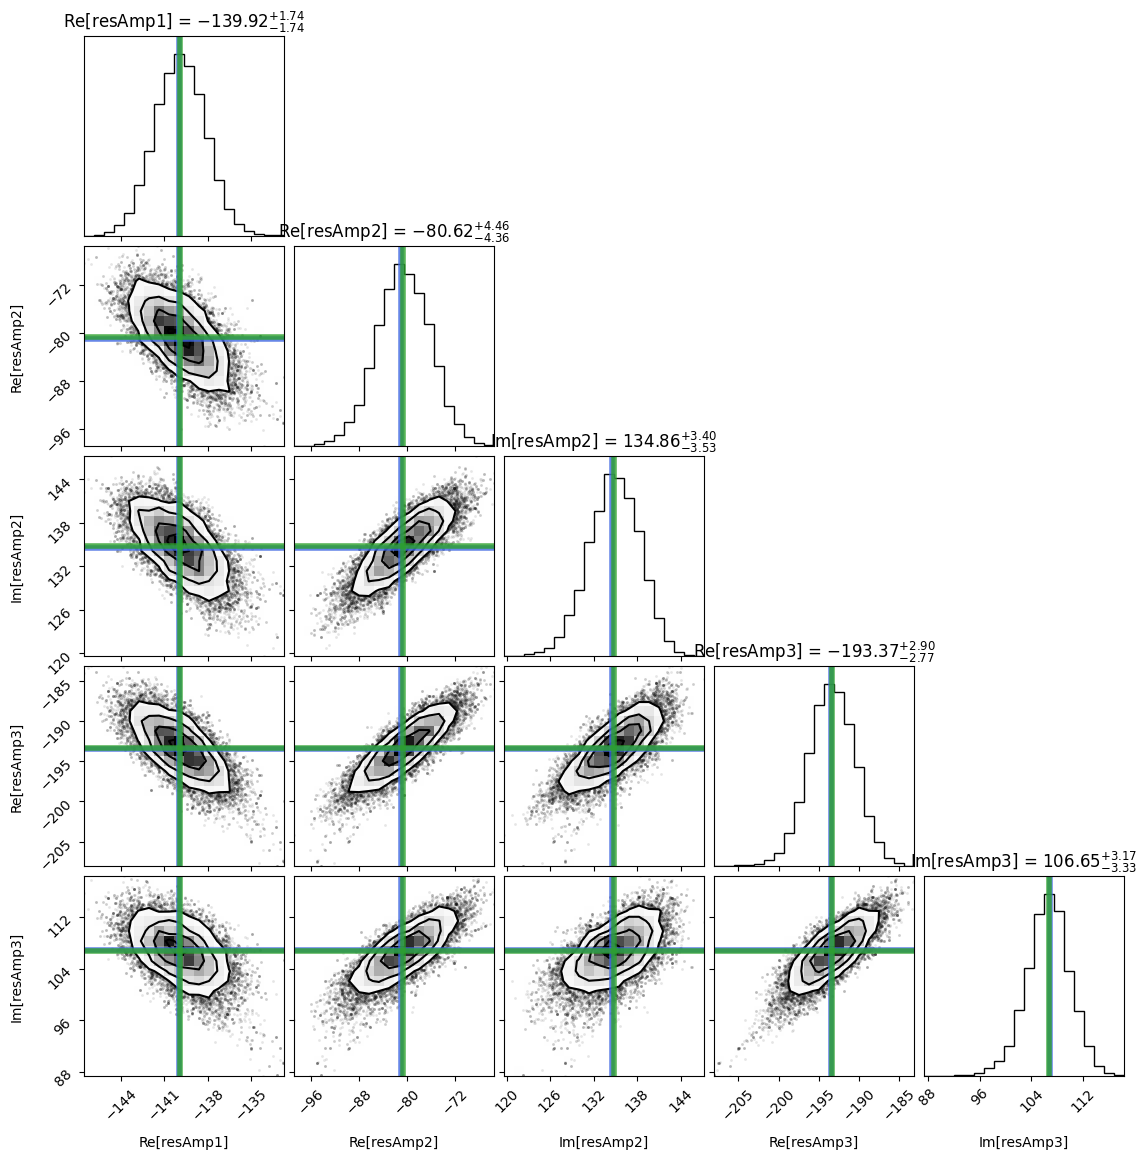

In [9]:
draw_corner(results, f'{ofolder}/{corner_ofile}')

We can see that the parameters are correlated. In this cfg file `resAmp1` is set to be real while `resAmp2` and `resAmp3` are freely floating complex numbers. It can be seen that resAmp1 is negatively correlated with the other parameters. The other parameters are uniformly positively correlated with each other.

# Additional arguments to `perform_mcmc`:
1. `params_dict` - provides ranges or initial values to initialize the walkers with. If you wish to understand the uncertainties around a MLE value, you can pass a dictionary of values: {parameter: value} and the walkers will be initialized around a N-dimensional Gaussian ball around. If you pass a range of values, then the walkers will be uniformly randomized on these intervals. 
2. `move_mixture` - The mixture of moves can have a significant effect on the results. Each move has a set of hyperparameters and an associated probability to be performed. In general, these moves attempt to create a balance between exploring the parameter space and exploiting (or local sampling) regions of high probability.

In [10]:
# Lets perform some cleanup again
!rm -r mcmc